# Business Problem

Credit card fraud is a growing concern in the financial sector, costing businesses and consumers billions of dollars annually. Fraudulent transactions often blend in with legitimate ones, making detection a complex task. Traditional rule-based fraud detection systems struggle to adapt to evolving fraud patterns, leading to false positives and missed fraudulent activities.

This section aims to develop a machine learning model using **Logistic Regression, RandomForest, XGBoost and LightGBM** to accurately detect fraudulent credit card transactions. After selecting the best model between them; we strive to enhance model performance, improve detection accuracy, and minimize false alarms by leveraging advanced hyperparameter tuning and GPU acceleration.

🎯 **Objectives:**
* Firstly, every process will be functionalized.
* Thoroughly analyze the dataset before the feature engineering and building a model.
* Preprocess the dataset via Feature engineering methods.
* Build a fraud detection model using Logistic Regression, RandomForest, XGBoost and LightGBM for classification.
* Select the best model and optimize model performance through GridSearchCV hyperparameter tuning.
* Evaluate results using accuracy, precision, recall, F1-score, confusion matrix, and ROC-AUC.
* Identify key features influencing fraud detection using feature importance analysis.

By implementing an efficient and well-tuned fraud detection model, this project aims to assist financial institutions in minimizing fraudulent activities, reducing financial losses, and improving security for consumers.

# Dataset Story

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

**It contains only numerical input variables which are the result of a PCA transformation.** Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. **Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.**

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

# Required Libraries

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

# scikitlearn related imports
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, r2_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# XGBoost and LightGBM
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# to save the model
import joblib

# pandas settings
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)

import warnings
warnings.filterwarnings("ignore")

# Importing Dataset

In [2]:
credit_df = pd.read_csv("Datasets_documents/creditcard.csv")
df = credit_df.copy()
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Exploratory Data Analysis (EDA)

## General Information About the Dataset

In [3]:
def check_df(dataframe, head=5, tail=5):
    print('*'*20, 'HEAD', '*'*20)
    print(dataframe.head(head))
    print('*'*20, 'TAIL', '*'*20)
    print(dataframe.tail(tail))
    print('*'*20, 'SHAPE', '*'*20)
    print(dataframe.shape)
    print('*'*20, 'TYPES', '*'*20)
    print(dataframe.dtypes)
    print('*'*20, 'SIZE', '*'*20)
    print(dataframe.size)
    print('*'*20, 'NA', '*'*20)
    print(dataframe.isnull().sum())
    print('*'*20, 'QUARTILES', '*'*20)
    print(dataframe.describe([0, 0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1]).T)

In [4]:
check_df(df)

******************** HEAD ********************
   Time        V1        V2        V3        V4        V5        V6        V7        V8        V9       V10       V11       V12       V13       V14       V15       V16       V17       V18       V19       V20       V21       V22       V23       V24       V25       V26       V27       V28  Amount  Class
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169  1.468177 -0.470401  0.207971  0.025791  0.403993  0.251412 -0.018307  0.277838 -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053  149.62      0
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772  0.635558  0.463917 -0.114805 -0.183361 -0.145783 -0.069083 -0.225775 -0.638672  0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724    2.69      0
2   1.0 -1.358354 -1.340163  1.773209  0.379

## Analysis of Categorical and Numerical Variables

In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20, report=False):
    # categorical
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["object", "bool", "category"]]
    num_but_cat = [col for col in dataframe.columns if (dataframe[col].nunique() < cat_th and str(dataframe[col].dtypes) in ["uint8", "int64", "float64"])]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ["category", "object"]]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # numerical
    num_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["int64", "float64", "uin8"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    if report:
        print(f"Observation: {dataframe.shape[0]}")
        print(f"Variables: {dataframe.shape[1]}")
        print(f"Categorical Features: {len(cat_cols)}")
        print(f"Numerical Features: {len(num_cols)}")
        print(f"High Cardinality Features: {len(cat_but_car)}")
        print(f"Numerical But Categorical Features: {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car, num_but_cat

In [6]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df, report=True)

Observation: 284807
Variables: 31
Categorical Features: 1
Numerical Features: 30
High Cardinality Features: 0
Numerical But Categorical Features: 1


In [7]:
def num_summary(dataframe, num_col, plot=False):
    print(20*"*", num_col, 20*"*")
    quantiles = [0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[num_col].describe(quantiles).T)

    if plot:
        sns.set()
        dataframe[num_col].hist(bins=20)
        plt.xlabel(num_col)
        plt.title(num_col)
        plt.show(block=True)

In [8]:
def num_summary_df(dataframe):
    cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
    for col in num_cols:
        num_summary(dataframe, col, plot=True)

******************** Time ********************
count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
1%         2422.000000
5%        25297.600000
10%       35027.000000
20%       47694.200000
30%       60776.000000
40%       73261.400000
50%       84692.000000
60%      120396.000000
70%      132929.000000
80%      145247.800000
90%      157640.400000
95%      164143.400000
99%      170560.940000
max      172792.000000
Name: Time, dtype: float64


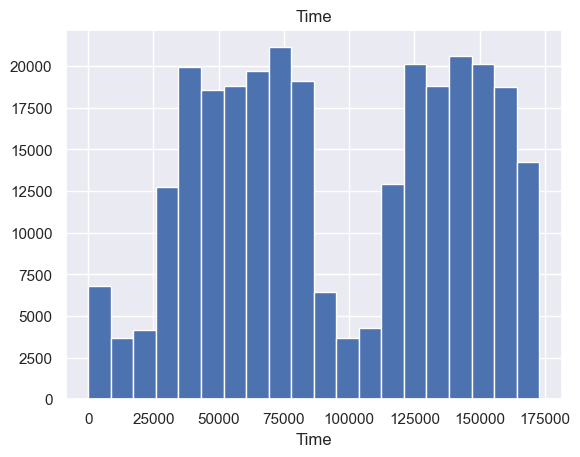

******************** V1 ********************
count    2.848070e+05
mean     1.168375e-15
std      1.958696e+00
min     -5.640751e+01
1%      -6.563199e+00
5%      -2.899147e+00
10%     -1.893272e+00
20%     -1.134663e+00
30%     -7.472943e-01
40%     -4.267559e-01
50%      1.810880e-02
60%      1.035107e+00
70%      1.224825e+00
80%      1.694936e+00
90%      2.015409e+00
95%      2.081223e+00
99%      2.237130e+00
max      2.454930e+00
Name: V1, dtype: float64


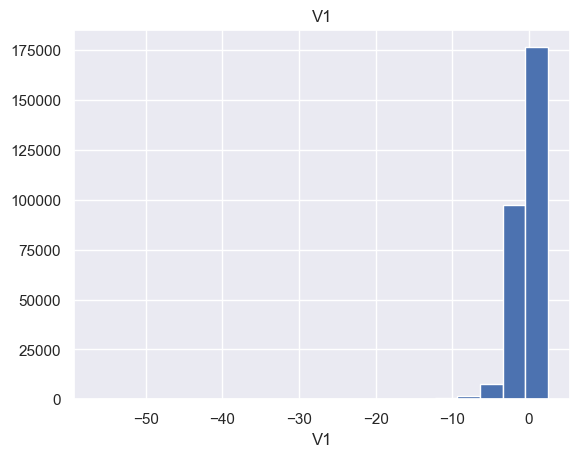

******************** V2 ********************
count    2.848070e+05
mean     3.416908e-16
std      1.651309e+00
min     -7.271573e+01
1%      -4.960300e+00
5%      -1.971975e+00
10%     -1.359862e+00
20%     -7.908142e-01
30%     -4.363931e-01
40%     -1.538049e-01
50%      6.548556e-02
60%      3.027378e-01
70%      6.368450e-01
80%      9.573136e-01
90%      1.326635e+00
95%      1.808585e+00
99%      3.801811e+00
max      2.205773e+01
Name: V2, dtype: float64


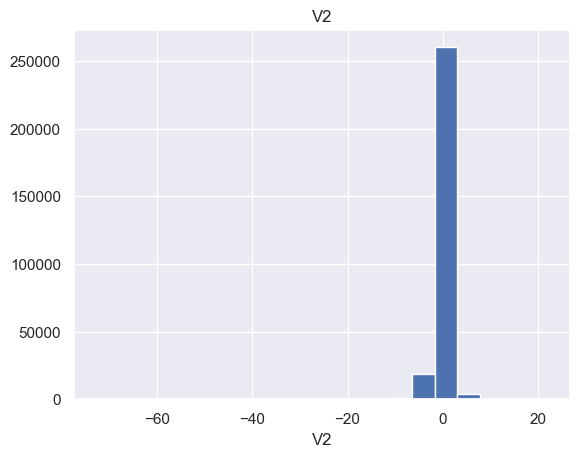

******************** V3 ********************
count    2.848070e+05
mean    -1.379537e-15
std      1.516255e+00
min     -4.832559e+01
1%      -3.978377e+00
5%      -2.389740e+00
10%     -1.802587e+00
20%     -1.169050e+00
30%     -6.168060e-01
40%     -1.990610e-01
50%      1.798463e-01
60%      4.970396e-01
70%      8.435405e-01
80%      1.215700e+00
90%      1.676173e+00
95%      2.062635e+00
99%      2.728434e+00
max      9.382558e+00
Name: V3, dtype: float64


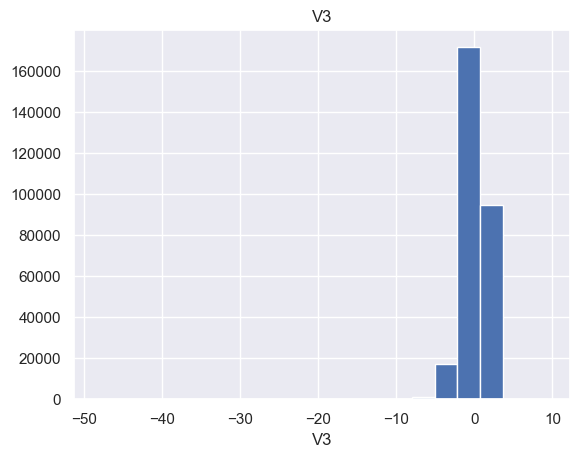

******************** V4 ********************
count    2.848070e+05
mean     2.074095e-15
std      1.415869e+00
min     -5.683171e+00
1%      -3.122987e+00
5%      -2.195683e+00
10%     -1.656329e+00
20%     -1.066085e+00
30%     -6.962262e-01
40%     -3.941610e-01
50%     -1.984653e-02
60%      2.848562e-01
70%      5.588663e-01
80%      9.861875e-01
90%      1.482807e+00
95%      2.566501e+00
99%      4.248032e+00
max      1.687534e+01
Name: V4, dtype: float64


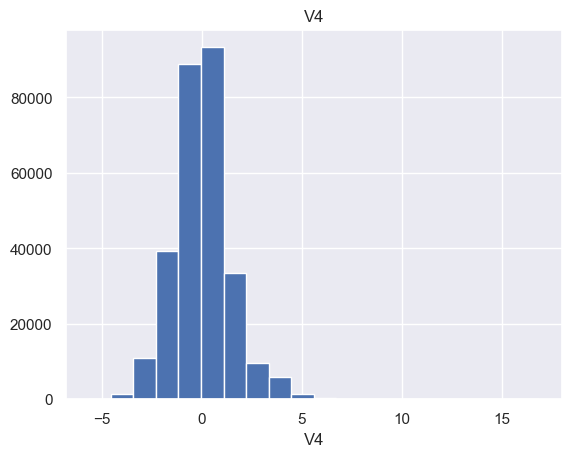

******************** V5 ********************
count    2.848070e+05
mean     9.604066e-16
std      1.380247e+00
min     -1.137433e+02
1%      -3.060396e+00
5%      -1.702021e+00
10%     -1.302171e+00
20%     -8.595815e-01
30%     -5.444552e-01
40%     -2.901118e-01
50%     -5.433583e-02
60%      1.866249e-01
70%      4.570287e-01
80%      8.022349e-01
90%      1.407893e+00
95%      2.098960e+00
99%      3.424903e+00
max      3.480167e+01
Name: V5, dtype: float64


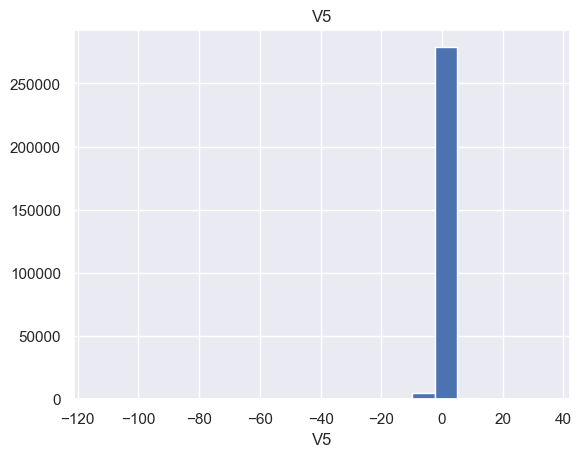

******************** V6 ********************
count    2.848070e+05
mean     1.487313e-15
std      1.332271e+00
min     -2.616051e+01
1%      -2.124023e+00
5%      -1.406757e+00
10%     -1.167450e+00
20%     -8.781527e-01
30%     -6.678449e-01
40%     -4.794725e-01
50%     -2.741871e-01
60%     -4.819964e-02
70%      2.232447e-01
80%      6.289952e-01
90%      1.509365e+00
95%      3.160382e+00
99%      4.200085e+00
max      7.330163e+01
Name: V6, dtype: float64


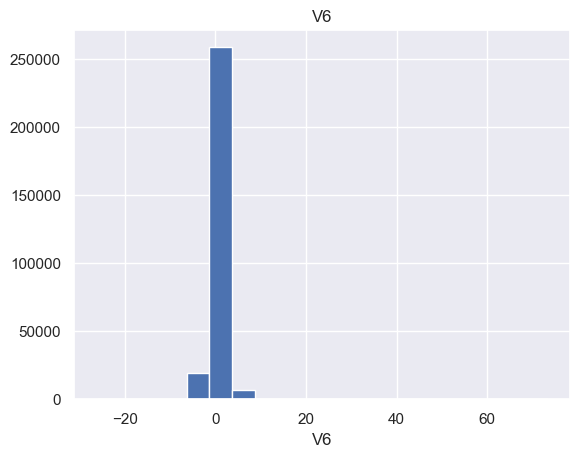

******************** V7 ********************
count    2.848070e+05
mean    -5.556467e-16
std      1.237094e+00
min     -4.355724e+01
1%      -3.012847e+00
5%      -1.434423e+00
10%     -1.078148e+00
20%     -6.833164e-01
30%     -4.260203e-01
40%     -1.593408e-01
50%      4.010308e-02
60%      2.135123e-01
70%      4.461749e-01
80%      6.983318e-01
90%      1.039387e+00
95%      1.407632e+00
99%      2.696205e+00
max      1.205895e+02
Name: V7, dtype: float64


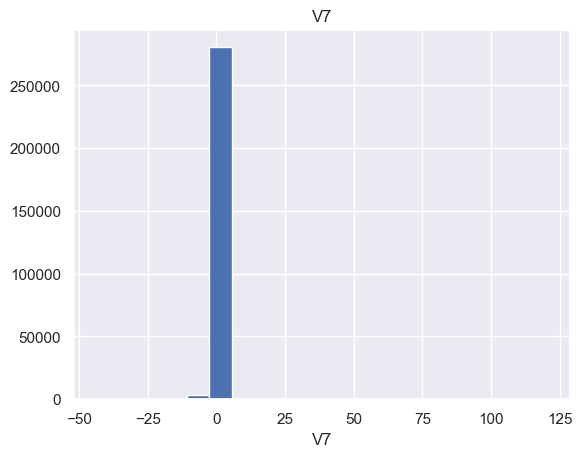

******************** V8 ********************
count    2.848070e+05
mean     1.213481e-16
std      1.194353e+00
min     -7.321672e+01
1%      -4.033899e+00
5%      -8.421469e-01
10%     -4.589454e-01
20%     -2.662999e-01
30%     -1.581584e-01
40%     -6.605715e-02
50%      2.235804e-02
60%      1.204889e-01
70%      2.434003e-01
80%      4.355289e-01
90%      7.693811e-01
95%      1.049984e+00
99%      2.075973e+00
max      2.000721e+01
Name: V8, dtype: float64


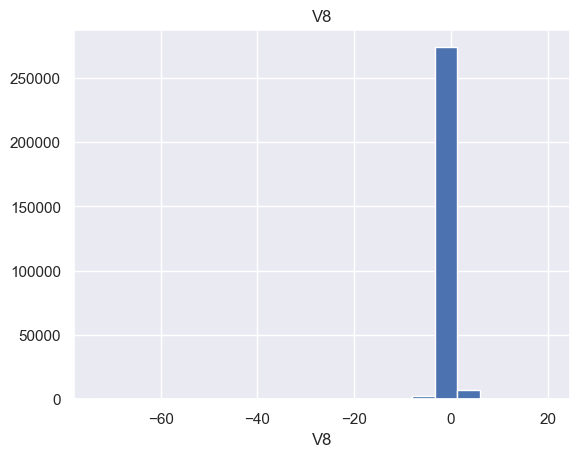

******************** V9 ********************
count    2.848070e+05
mean    -2.406331e-15
std      1.098632e+00
min     -1.343407e+01
1%      -2.455288e+00
5%      -1.758426e+00
10%     -1.294047e+00
20%     -8.088755e-01
30%     -5.021651e-01
40%     -2.577302e-01
50%     -5.142873e-02
60%      1.761695e-01
70%      4.459420e-01
80%      7.915832e-01
90%      1.301671e+00
95%      1.780783e+00
99%      2.986773e+00
max      1.559499e+01
Name: V9, dtype: float64


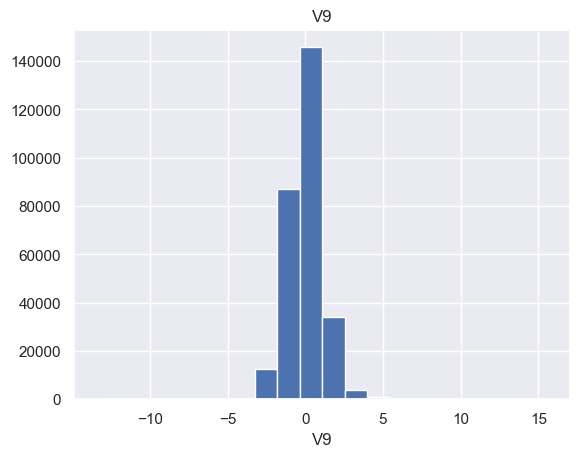

******************** V10 ********************
count    2.848070e+05
mean     2.239053e-15
std      1.088850e+00
min     -2.458826e+01
1%      -2.092670e+00
5%      -1.338636e+00
10%     -1.032158e+00
20%     -6.664809e-01
30%     -4.257577e-01
40%     -2.481867e-01
50%     -9.291738e-02
60%      5.950018e-02
70%      2.695355e-01
80%      6.482390e-01
90%      1.119759e+00
95%      1.548557e+00
99%      3.253618e+00
max      2.374514e+01
Name: V10, dtype: float64


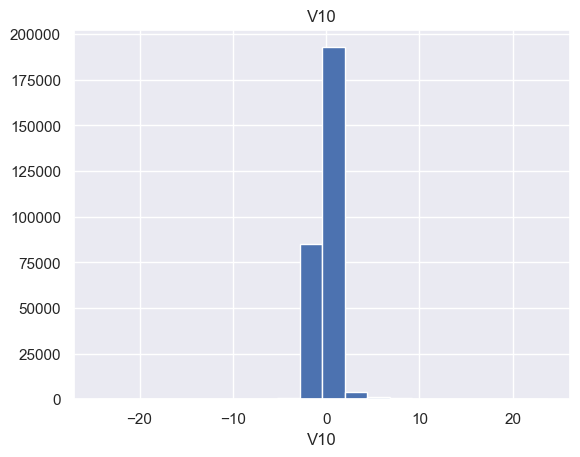

******************** V11 ********************
count    2.848070e+05
mean     1.673327e-15
std      1.020713e+00
min     -4.797473e+00
1%      -2.093086e+00
5%      -1.571901e+00
10%     -1.289015e+00
20%     -9.169940e-01
30%     -6.129743e-01
40%     -3.171382e-01
50%     -3.275735e-02
60%      2.678527e-01
70%      5.785726e-01
80%      9.132205e-01
90%      1.318588e+00
95%      1.614033e+00
99%      2.290583e+00
max      1.201891e+01
Name: V11, dtype: float64


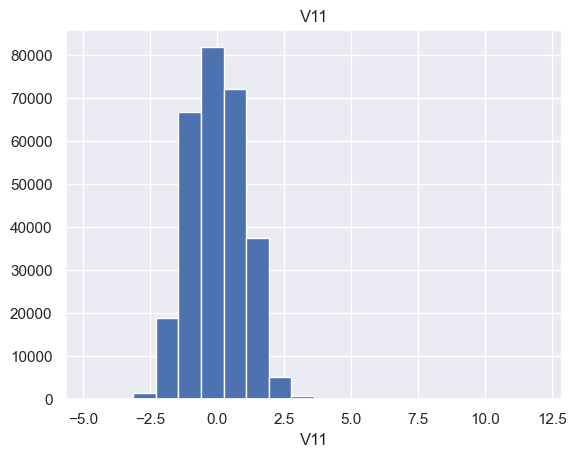

******************** V12 ********************
count    2.848070e+05
mean    -1.247012e-15
std      9.992014e-01
min     -1.868371e+01
1%      -3.063938e+00
5%      -1.967162e+00
10%     -1.148031e+00
20%     -5.730710e-01
30%     -2.719676e-01
40%     -5.045118e-02
50%      1.400326e-01
60%      3.247704e-01
70%      5.164565e-01
80%      7.306695e-01
90%      1.017274e+00
95%      1.243053e+00
99%      1.698576e+00
max      7.848392e+00
Name: V12, dtype: float64


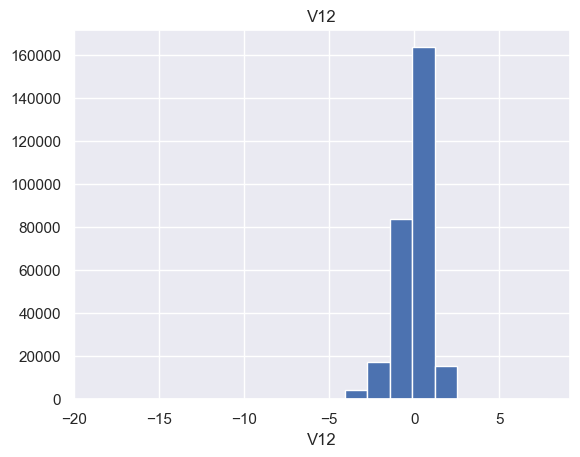

******************** V13 ********************
count    2.848070e+05
mean     8.190001e-16
std      9.952742e-01
min     -5.791881e+00
1%      -2.283101e+00
5%      -1.639729e+00
10%     -1.280012e+00
20%     -8.247022e-01
30%     -4.971726e-01
40%     -2.395771e-01
50%     -1.356806e-02
60%      2.287273e-01
70%      5.050463e-01
80%      8.290889e-01
90%      1.251841e+00
95%      1.607877e+00
99%      2.513962e+00
max      7.126883e+00
Name: V13, dtype: float64


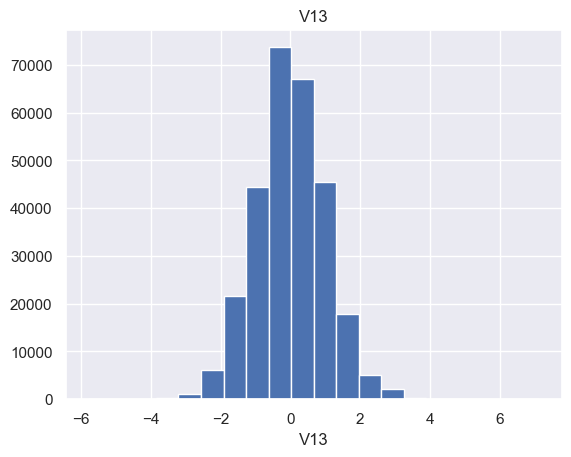

******************** V14 ********************
count    2.848070e+05
mean     1.207294e-15
std      9.585956e-01
min     -1.921433e+01
1%      -2.799763e+00
5%      -1.439351e+00
10%     -1.003676e+00
20%     -5.673035e-01
30%     -3.124565e-01
40%     -1.196655e-01
50%      5.060132e-02
60%      2.163083e-01
70%      3.938939e-01
80%      6.087367e-01
90%      9.814085e-01
95%      1.393653e+00
99%      2.150300e+00
max      1.052677e+01
Name: V14, dtype: float64


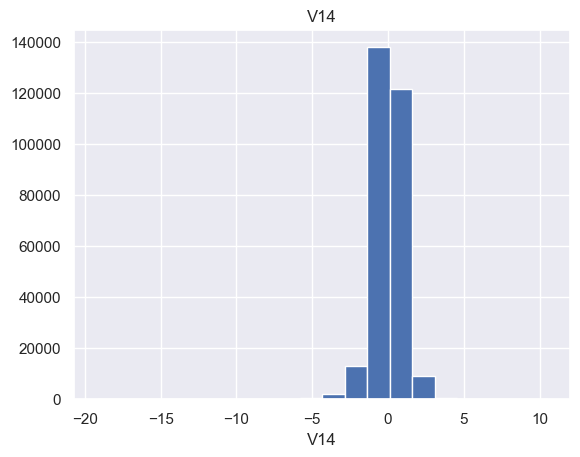

******************** V15 ********************
count    2.848070e+05
mean     4.887456e-15
std      9.153160e-01
min     -4.498945e+00
1%      -2.383923e+00
5%      -1.593200e+00
10%     -1.173945e+00
20%     -7.487495e-01
30%     -4.385696e-01
40%     -1.887507e-01
50%      4.807155e-02
60%      2.719566e-01
70%      5.137259e-01
80%      7.950543e-01
90%      1.124211e+00
95%      1.373090e+00
99%      1.925527e+00
max      8.877742e+00
Name: V15, dtype: float64


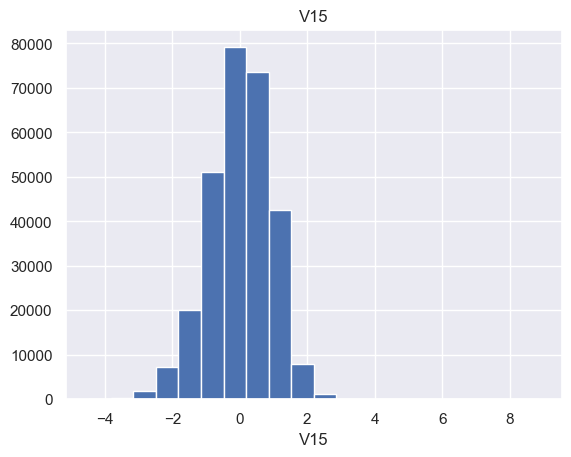

******************** V16 ********************
count    2.848070e+05
mean     1.437716e-15
std      8.762529e-01
min     -1.412985e+01
1%      -2.381823e+00
5%      -1.491663e+00
10%     -1.059361e+00
20%     -6.164855e-01
30%     -3.429957e-01
40%     -1.252125e-01
50%      6.641332e-02
60%      2.415156e-01
70%      4.264627e-01
80%      6.414430e-01
90%      9.908792e-01
95%      1.325253e+00
99%      1.874820e+00
max      1.731511e+01
Name: V16, dtype: float64


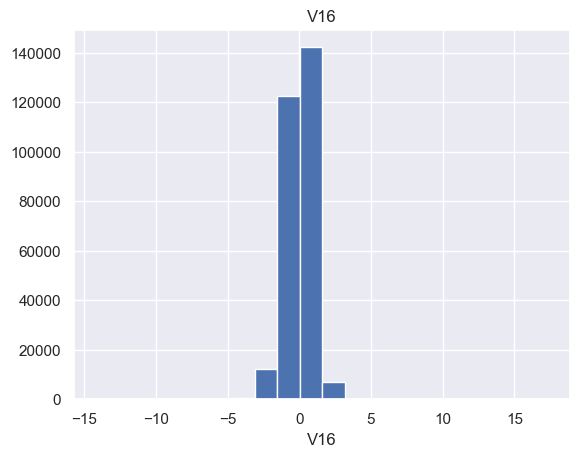

******************** V17 ********************
count    2.848070e+05
mean    -3.772171e-16
std      8.493371e-01
min     -2.516280e+01
1%      -1.349962e+00
5%      -9.830039e-01
10%     -8.042644e-01
20%     -5.757627e-01
30%     -3.969463e-01
40%     -2.355630e-01
50%     -6.567575e-02
60%      1.048739e-01
70%      2.967888e-01
80%      5.189160e-01
90%      9.086165e-01
95%      1.274609e+00
99%      2.289928e+00
max      9.253526e+00
Name: V17, dtype: float64


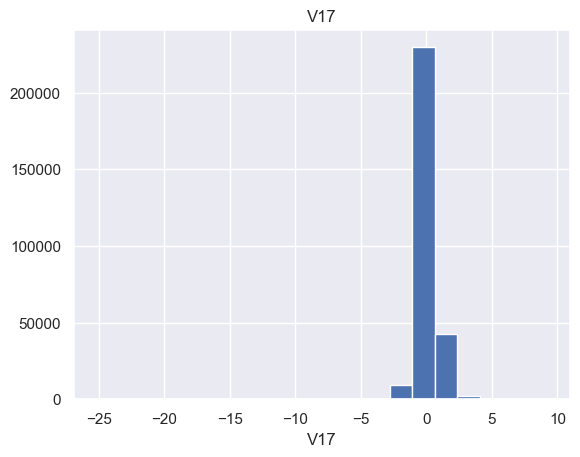

******************** V18 ********************
count    2.848070e+05
mean     9.564149e-16
std      8.381762e-01
min     -9.498746e+00
1%      -2.147067e+00
5%      -1.358094e+00
10%     -9.769348e-01
20%     -6.267061e-01
30%     -3.856909e-01
40%     -1.855848e-01
50%     -3.636312e-03
60%      1.820904e-01
70%      3.830896e-01
80%      6.374684e-01
90%      1.020455e+00
95%      1.394392e+00
99%      2.068689e+00
max      5.041069e+00
Name: V18, dtype: float64


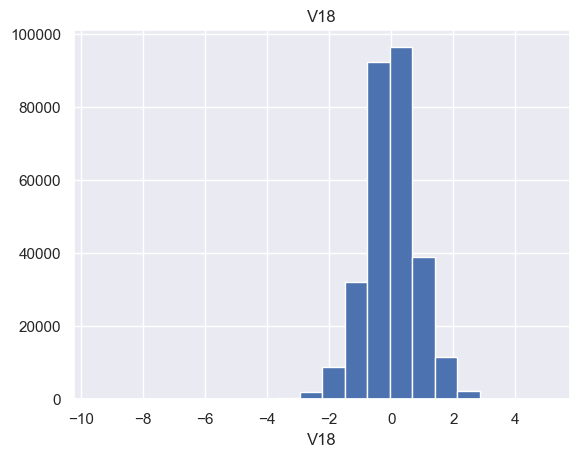

******************** V19 ********************
count    2.848070e+05
mean     1.039917e-15
std      8.140405e-01
min     -7.213527e+00
1%      -2.075516e+00
5%      -1.356259e+00
10%     -9.856163e-01
20%     -5.828234e-01
30%     -3.451006e-01
40%     -1.620252e-01
50%      3.734823e-03
60%      1.679275e-01
70%      3.482341e-01
80%      5.856940e-01
90%      9.538328e-01
95%      1.286164e+00
99%      2.262924e+00
max      5.591971e+00
Name: V19, dtype: float64


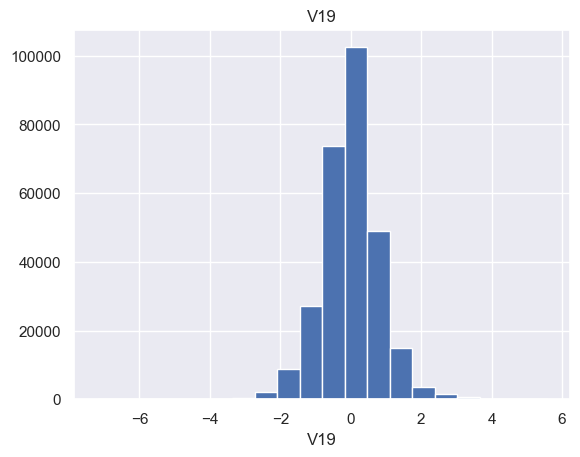

******************** V20 ********************
count    2.848070e+05
mean     6.406204e-16
std      7.709250e-01
min     -5.449772e+01
1%      -1.568406e+00
5%      -5.584349e-01
10%     -3.896021e-01
20%     -2.512018e-01
30%     -1.787040e-01
40%     -1.208067e-01
50%     -6.248109e-02
60%      4.307150e-03
70%      8.338735e-02
80%      1.957871e-01
90%      4.445929e-01
95%      8.361441e-01
99%      2.412190e+00
max      3.942090e+01
Name: V20, dtype: float64


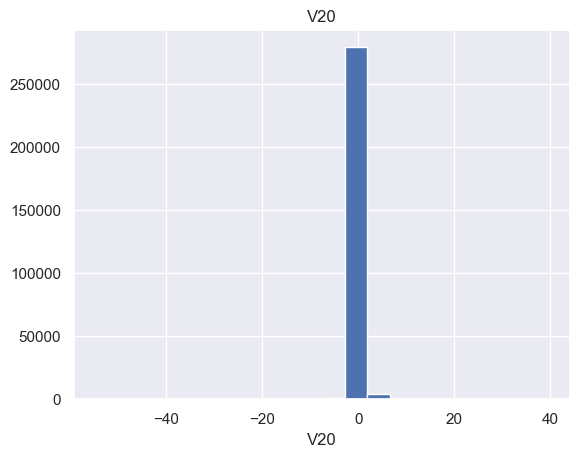

******************** V21 ********************
count    2.848070e+05
mean     1.654067e-16
std      7.345240e-01
min     -3.483038e+01
1%      -1.469679e+00
5%      -5.046735e-01
10%     -3.674467e-01
20%     -2.663929e-01
30%     -1.878180e-01
40%     -1.064266e-01
50%     -2.945017e-02
60%      5.038722e-02
70%      1.379046e-01
80%      2.354311e-01
90%      3.761555e-01
95%      5.378677e-01
99%      1.931852e+00
max      2.720284e+01
Name: V21, dtype: float64


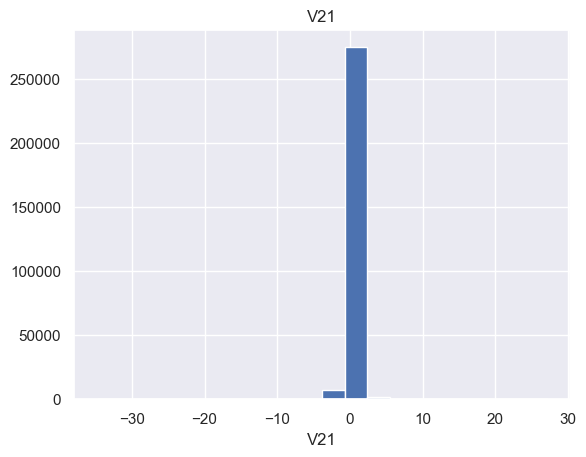

******************** V22 ********************
count    2.848070e+05
mean    -3.568593e-16
std      7.257016e-01
min     -1.093314e+01
1%      -1.654625e+00
5%      -1.081892e+00
10%     -8.674884e-01
20%     -6.416046e-01
30%     -4.344265e-01
40%     -2.018541e-01
50%      6.781943e-03
60%      2.005957e-01
70%      4.127470e-01
80%      6.485158e-01
90%      9.148826e-01
95%      1.128987e+00
99%      1.530152e+00
max      1.050309e+01
Name: V22, dtype: float64


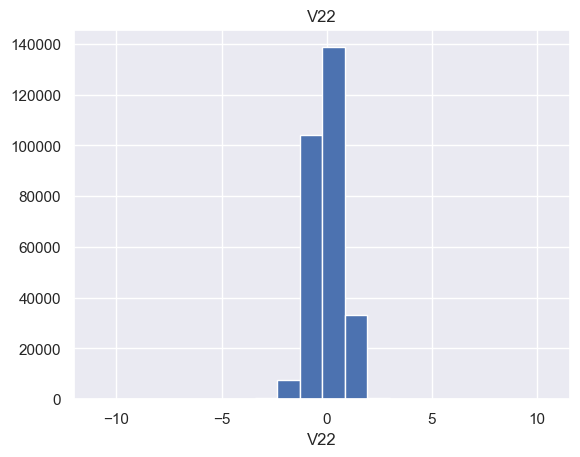

******************** V23 ********************
count    2.848070e+05
mean     2.578648e-16
std      6.244603e-01
min     -4.480774e+01
1%      -1.193417e+00
5%      -4.722464e-01
10%     -3.286342e-01
20%     -2.037425e-01
30%     -1.261571e-01
40%     -6.512670e-02
50%     -1.119293e-02
60%      4.484023e-02
70%      1.092714e-01
80%      1.942589e-01
90%      3.392860e-01
95%      4.880160e-01
99%      1.508703e+00
max      2.252841e+01
Name: V23, dtype: float64


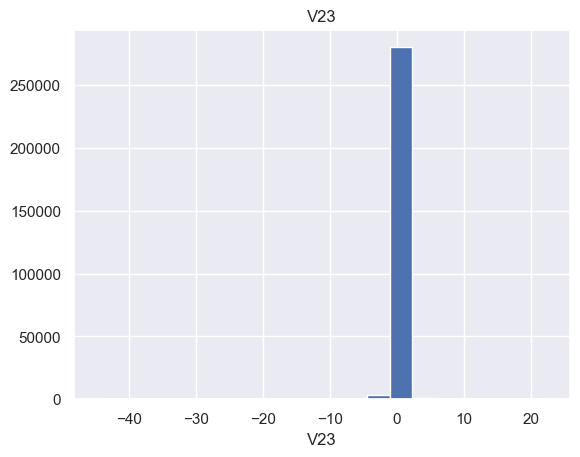

******************** V24 ********************
count    2.848070e+05
mean     4.473266e-15
std      6.056471e-01
min     -2.836627e+00
1%      -1.657308e+00
5%      -1.143662e+00
10%     -8.703584e-01
20%     -4.442769e-01
30%     -2.635025e-01
40%     -4.580667e-02
50%      4.097606e-02
60%      1.664115e-01
70%      3.742132e-01
80%      5.323465e-01
90%      7.054036e-01
95%      8.663576e-01
99%      1.063748e+00
max      4.584549e+00
Name: V24, dtype: float64


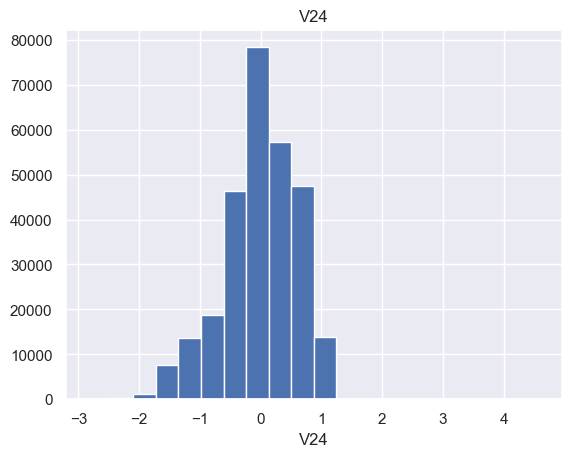

******************** V25 ********************
count    2.848070e+05
mean     5.340915e-16
std      5.212781e-01
min     -1.029540e+01
1%      -1.420859e+00
5%      -8.250264e-01
10%     -6.061010e-01
20%     -3.917190e-01
30%     -2.583651e-01
40%     -1.288661e-01
50%      1.659350e-02
60%      1.586211e-01
70%      2.849178e-01
80%      4.175428e-01
90%      6.009027e-01
95%      7.606986e-01
99%      1.203955e+00
max      7.519589e+00
Name: V25, dtype: float64


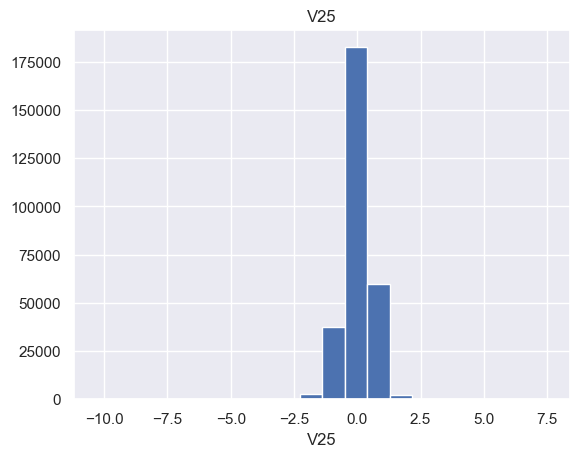

******************** V26 ********************
count    2.848070e+05
mean     1.683437e-15
std      4.822270e-01
min     -2.604551e+00
1%      -1.009384e+00
5%      -6.973483e-01
10%     -5.480343e-01
20%     -3.895481e-01
30%     -2.744373e-01
40%     -1.663338e-01
50%     -5.213911e-02
60%      8.611185e-02
70%      1.751137e-01
80%      3.602736e-01
90%      6.889469e-01
95%      9.209154e-01
99%      1.158698e+00
max      3.517346e+00
Name: V26, dtype: float64


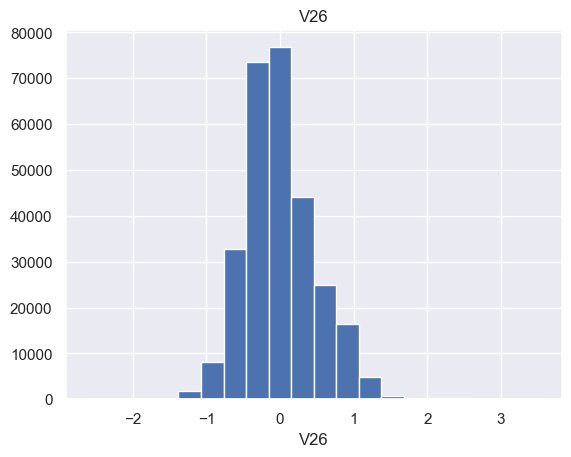

******************** V27 ********************
count    2.848070e+05
mean    -3.660091e-16
std      4.036325e-01
min     -2.256568e+01
1%      -1.247746e+00
5%      -4.152460e-01
10%     -2.114656e-01
20%     -9.111428e-02
30%     -5.423468e-02
40%     -2.436683e-02
50%      1.342146e-03
60%      2.922621e-02
70%      6.315093e-02
80%      1.352785e-01
90%      2.653679e-01
95%      3.877462e-01
99%      9.313604e-01
max      3.161220e+01
Name: V27, dtype: float64


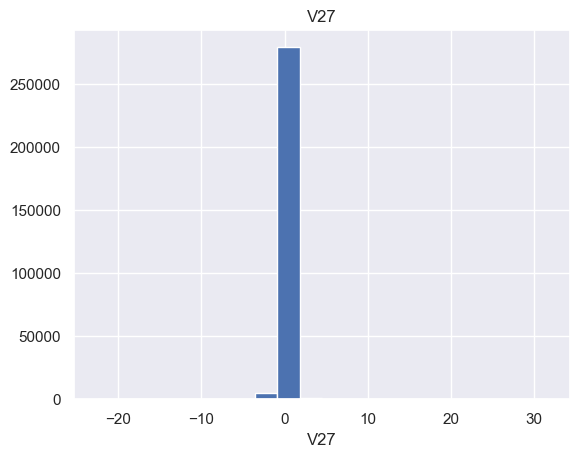

******************** V28 ********************
count    2.848070e+05
mean    -1.227390e-16
std      3.300833e-01
min     -1.543008e+01
1%      -8.762654e-01
5%      -3.178432e-01
10%     -1.556155e-01
20%     -6.544115e-02
30%     -4.026708e-02
40%     -1.195983e-02
50%      1.124383e-02
60%      2.692801e-02
70%      5.350104e-02
80%      1.013742e-01
90%      1.799362e-01
95%      2.560897e-01
99%      5.411264e-01
max      3.384781e+01
Name: V28, dtype: float64


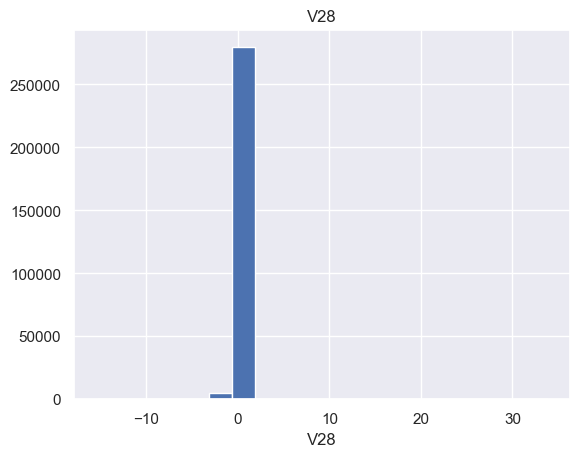

******************** Amount ********************
count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
1%            0.120000
5%            0.920000
10%           1.000000
20%           3.570000
30%           8.910000
40%          13.000000
50%          22.000000
60%          37.000000
70%          59.800000
80%         100.000000
90%         203.000000
95%         365.000000
99%        1017.970000
max       25691.160000
Name: Amount, dtype: float64


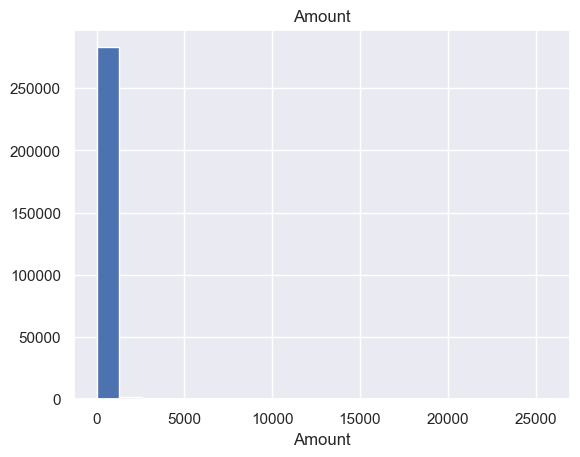

In [9]:
num_summary_df(df)

In [10]:
def plot_num_summary(dataframe):
    cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
    num_plots = len(num_cols)
    rows = math.ceil(num_plots/2)
    cols = 2 if num_plots > 1 else 1
    plt.figure(figsize=(10*cols, 4*rows))
    for index, col in enumerate(num_cols):
        plt.subplot(rows, cols, index+1)
        plt.tight_layout()
        dataframe[col].hist(bins=20)
        plt.title(col)

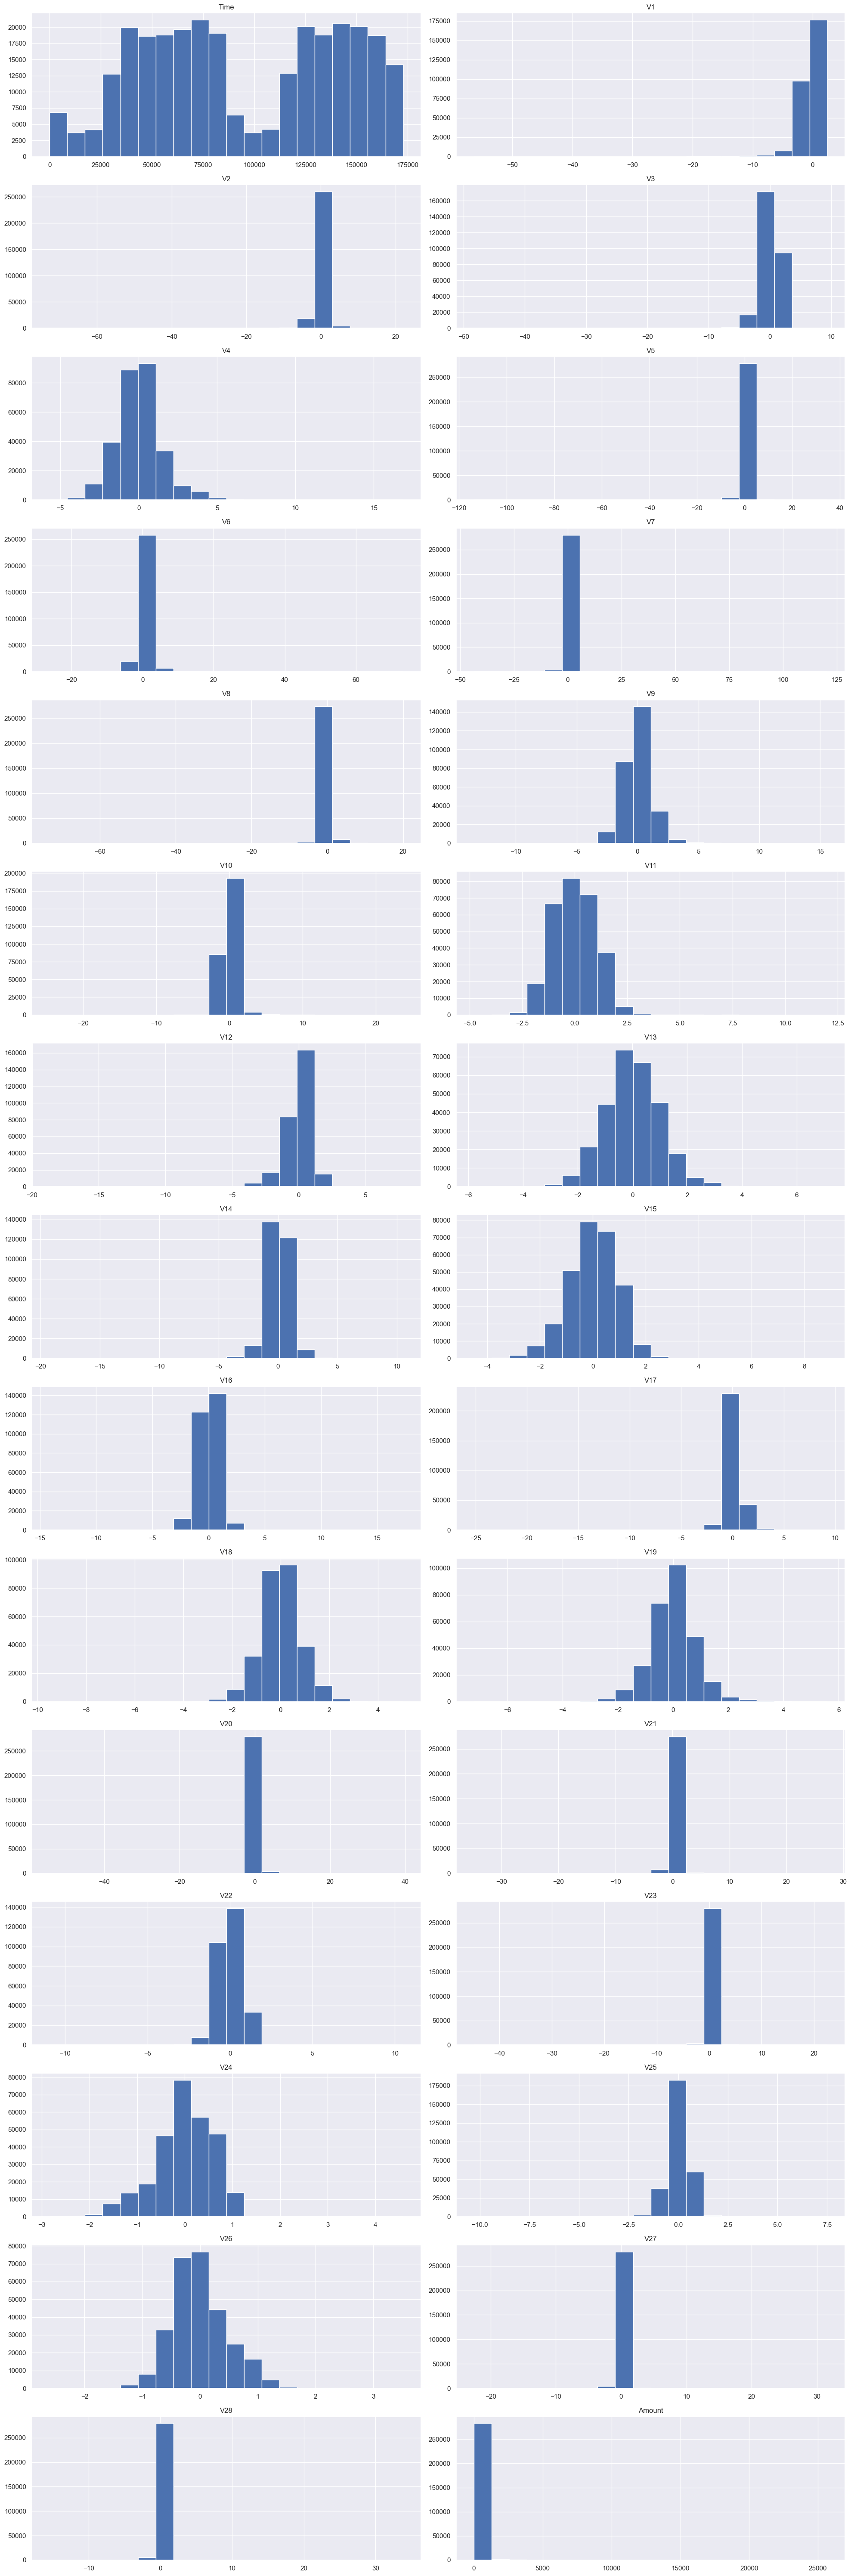

In [11]:
plot_num_summary(df)

## Target Analysis

In [12]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(20*"*", target, "===>", numerical_col, 20*"*")
    if ("cat_" + target) in dataframe.columns:
        print(pd.DataFrame({"Target Mean": dataframe.groupby("cat_" + target)[numerical_col].mean()}))
    else:
        print(pd.DataFrame({"Target Mean": dataframe.groupby(target)[numerical_col].mean()}))

In [13]:
def target_summary_with_num_df(dataframe, target):
    cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(dataframe)
    for col in num_cols:
        if col == target:
            continue
        else:
            target_summary_with_num(dataframe, target, col)

In [14]:
target_summary_with_num_df(df, "Class")

******************** Class ===> Time ********************
        Target Mean
Class              
0      94838.202258
1      80746.806911
******************** Class ===> V1 ********************
       Target Mean
Class             
0         0.008258
1        -4.771948
******************** Class ===> V2 ********************
       Target Mean
Class             
0        -0.006271
1         3.623778
******************** Class ===> V3 ********************
       Target Mean
Class             
0         0.012171
1        -7.033281
******************** Class ===> V4 ********************
       Target Mean
Class             
0        -0.007860
1         4.542029
******************** Class ===> V5 ********************
       Target Mean
Class             
0         0.005453
1        -3.151225
******************** Class ===> V6 ********************
       Target Mean
Class             
0         0.002419
1        -1.397737
******************** Class ===> V7 ********************
       Target 

## Correlation Analysis

In [15]:
def high_correlated_cols(dataframe, corr_th=0.90, remove=False, plot=False):
    num_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["int64", "float64", "uint8"]]
    corr = dataframe[num_cols].corr()
    corr_matrix = corr.abs()
    upper_triangle_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if drop_list == []:
        print(20*"*", "After Correlation Analysis, You Don't Need to Remove Any Variables", 20*"*")
    if remove:
        dataframe = dataframe.drop(drop_list, axis=1)
    if plot:
        num_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["int64", "float64", "uint8"]]
        plt.figure(figsize=(int(dataframe.shape[1]), int(dataframe.shape[1])))
        sns.heatmap(dataframe[num_cols].corr(), cmap="RdBu", annot=True)
        plt.show(block=True)
    return drop_list

******************** After Correlation Analysis, You Don't Need to Remove Any Variables ********************


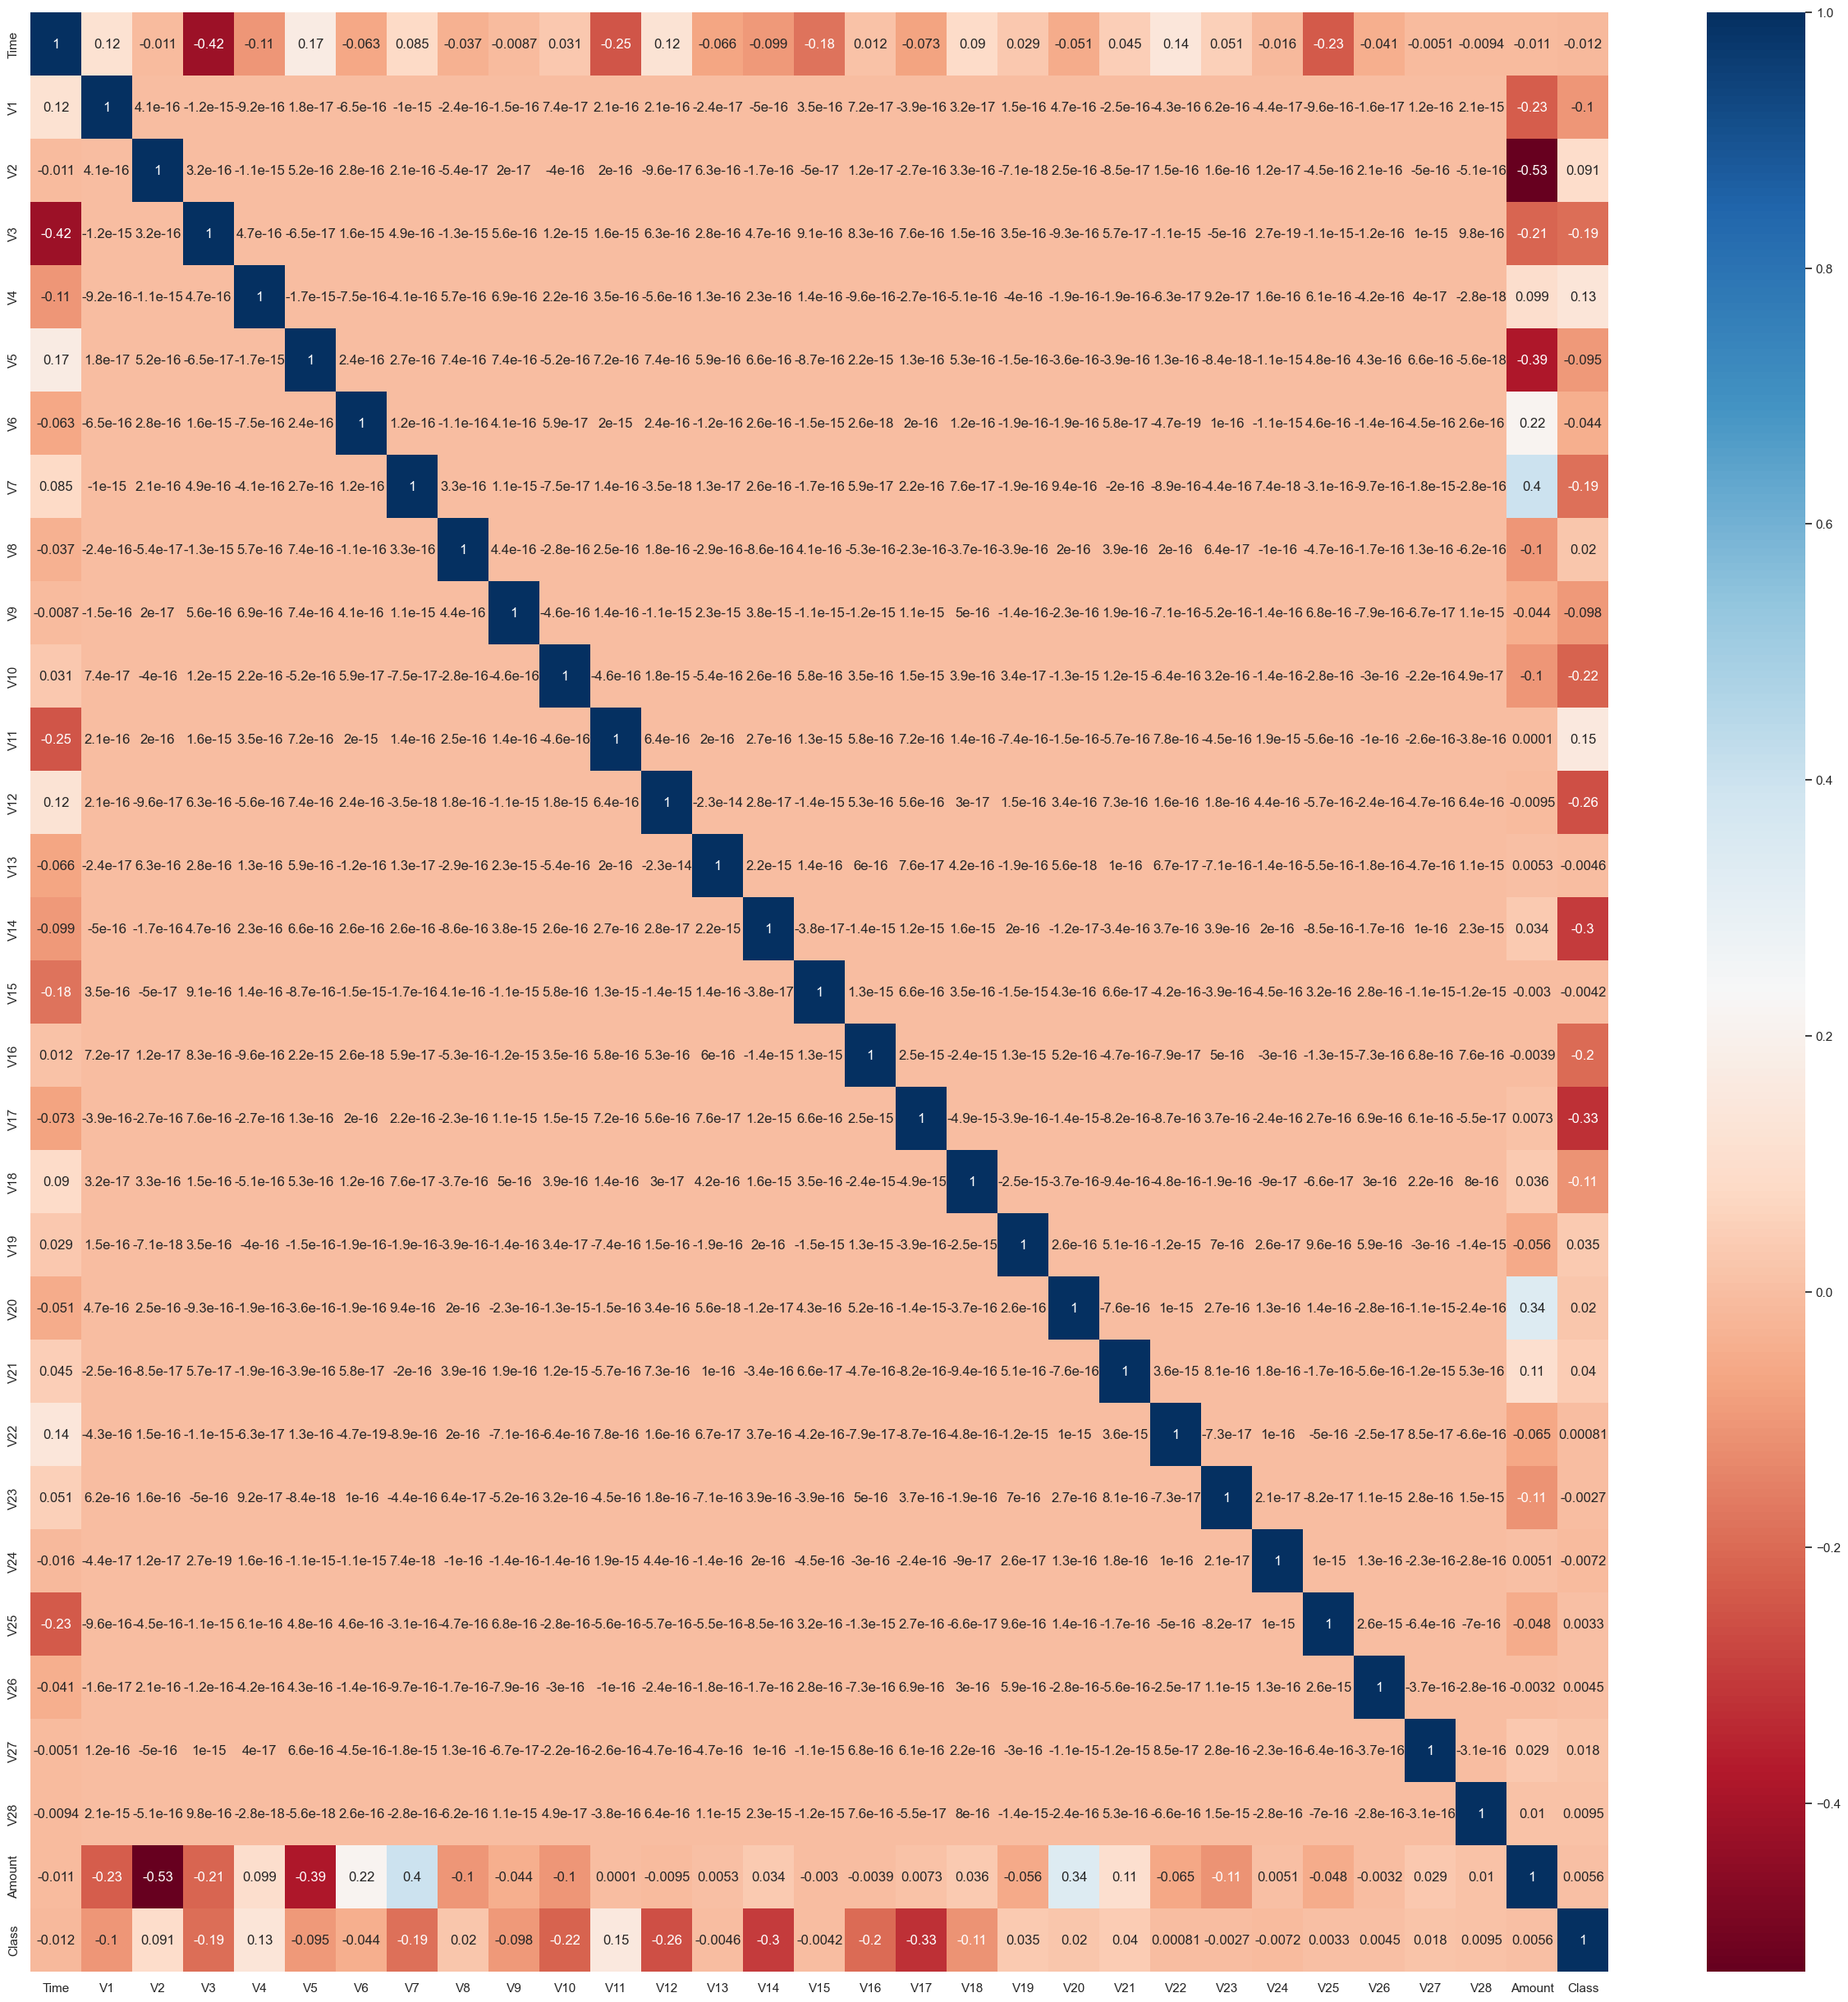

[]

In [16]:
high_correlated_cols(df, plot=True)

# Feature Engineering

## Missing Value Analysis

In [17]:
df.isnull().sum().sum()
# there is no missing value

0

## Feature Scaling

In [18]:
def robust_scaler_dataframe(dataframe):
  temp_df = dataframe.copy()
  rs = RobustScaler()
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(temp_df)
  for col in num_cols:
    temp_df[col] = rs.fit_transform(temp_df[[col]])
  return temp_df

In [19]:
# since we do not apply outlier analysis, it would be better to scale the dataset and normalize the features
df = robust_scaler_dataframe(df)

In [20]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.994983,-0.616237,-0.098602,1.228905,0.878152,-0.217859,0.631245,0.177406,0.142432,0.334787,0.185689,-0.345414,-0.740209,-0.745834,-0.393775,1.152959,-0.541507,0.309758,0.029437,0.437322,0.910463,0.026866,0.253109,-0.320791,0.032681,0.167619,-0.241182,0.816731,-0.246091,1.783274,0
1,-0.994983,0.524929,0.143100,-0.006970,0.293974,0.087726,0.164395,-0.105740,0.117064,-0.164482,-0.074854,1.095465,0.903686,0.383407,-0.211569,0.476970,0.400979,-0.055612,-0.179787,-0.163363,-0.019150,-0.473332,-0.602719,0.363442,-0.479557,0.225462,0.313475,-0.063781,0.026519,-0.269825,0
2,-0.994972,-0.615587,-1.002407,0.830932,0.251024,-0.344345,1.778007,0.668164,0.420388,-1.179796,0.303796,0.437564,-0.072229,0.557465,-0.235704,1.865539,-2.982344,1.330783,-0.117763,-2.475385,1.703959,0.668917,0.714254,2.974603,-0.919589,-0.515430,-0.153111,-0.350218,-0.540962,4.983721,0
3,-0.994972,-0.440239,-0.178789,0.841250,-0.529808,0.033775,1.303832,0.175637,0.662489,-1.076888,0.038374,-0.128974,0.037307,0.397641,-0.368473,-0.551666,-1.135905,-0.700023,1.970088,-1.350843,-0.422194,-0.190105,-0.001408,-0.578786,-1.531963,0.944482,-0.298959,0.379163,0.382611,1.418291,0
4,-0.994960,-0.526089,0.579239,0.713861,0.265632,-0.270695,0.317183,0.491625,-0.546463,0.700808,0.855099,-0.525992,0.388903,1.036898,-1.273801,0.103149,-0.522390,-0.193970,-0.034570,0.873809,1.366227,0.048266,0.739092,-0.407980,0.126293,-0.333308,0.976221,1.347133,1.553716,0.670579,0


## Checking Imbalance

In [21]:
# Imbalance ratio is checked because the dataset is indicated as highly imbalanced
def check_imbalance(dataframe, target, classes=[]):
  target_values = dataframe[target].unique()
  class_sum = [np.sum(dataframe[target] == target_values[i]) for i in range(dataframe[target].nunique())]

  if len(classes) == 0:
    for i in range(dataframe[target].nunique()):
      print(f"Count of Class {target_values[i]}: {class_sum[i]}")
    if len(target_values) == 2:
      print(f"Class Ratio: {(100 / (class_sum[0] / class_sum[1])):.2f}%")

  else:
    for i in range(dataframe[target].nunique()):
      print(f"{classes[i]} {target_values[i]}: {class_sum[i]}")
    if len(target_values) == 2:
      print(f"{classes[0]} - {classes[1]} Ratio: {(100 / (class_sum[0] / class_sum[1])):.2f}%")

In [22]:
check_imbalance(df, "Class", classes=["Non Fraud Cases", "Fraud Cases"])

Non Fraud Cases 0: 284315
Fraud Cases 1: 492
Non Fraud Cases - Fraud Cases Ratio: 0.17%


# Creating Base Models

In [23]:
def Create_Train_All_Classification_Models(dataframe, target, test_size=0.20, cv=3,results=False, save_results=False, plot=False):
    X = dataframe.drop(target, axis=1)
    y = dataframe[target]

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    results_dict = {
        "Model_Names": [],
        "ACC_Test": [],
        "Precision": [],
        "Recall": [],
        "F1-Score": [],
        "Roc_Auc": []
    }

    # Model instances in a dict
    models = (
        ("Logistic", LogisticRegression(class_weight="balanced", max_iter=500)),
        ("RF", RandomForestClassifier(n_estimators=100, max_depth=10, class_weight="balanced", n_jobs=-1, random_state=42)),
        ("XGBoost", XGBClassifier(scale_pos_weight=10, eval_metric="logloss", use_label_encoder=False, random_state=42)),
        ("LightGBM", LGBMClassifier(is_unbalance=True, n_estimators=100, random_state=42, verbose=-1))
    )

    print("="*50, "Model Results", "="*50)

    for name, classifier in models:
        acc_test, precision, recall, f1, roc_auc = [], [], [], [], []

        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            classifier.fit(X_train, y_train)
            y_test_pred = classifier.predict(X_test)

            acc_test.append(accuracy_score(y_test, y_test_pred))
            precision.append(precision_score(y_test, y_test_pred))
            recall.append(recall_score(y_test, y_test_pred))
            f1.append(f1_score(y_test, y_test_pred))
            roc_auc.append(roc_auc_score(y_test, y_test_pred))

        # Average scores
        results_dict["Model_Names"].append(name)
        results_dict["ACC_Test"].append(sum(acc_test) / len(acc_test))
        results_dict["Precision"].append(sum(precision) / len(precision))
        results_dict["Recall"].append(sum(recall) / len(recall))
        results_dict["F1-Score"].append(sum(f1) / len(f1))
        results_dict["Roc_Auc"].append(sum(roc_auc) / len(roc_auc))

        # Saving the trained model
        with open(f"{name}_model.pkl", "wb") as file:
            joblib.dump(classifier, file)

    model_results = pd.DataFrame(results_dict).set_index("Model_Names")
    model_results = model_results.sort_values(by="F1-Score", ascending=False)

    if results:
        print(model_results)

    if save_results:
        model_results.to_csv("model_results.csv")

    if plot:
        plt.figure(figsize=(10, 6))
        sns.barplot(x="F1-Score", y=model_results.index, data=model_results, color="r")
        plt.xlabel("F1-Score")
        plt.ylabel("Model Names")
        plt.title("F1-Score for All Classification Models")
        plt.show()

    return model_results

================================================== Model Results ==================================================
             ACC_Test  Precision    Recall  F1-Score   Roc_Auc
Model_Names                                                   
XGBoost      0.999593   0.943888  0.813008  0.873450  0.906462
RF           0.999442   0.869459  0.796748  0.831427  0.898270
Logistic     0.976826   0.064372  0.910569  0.120185  0.943755
LightGBM     0.950974   0.030581  0.863821  0.059019  0.907473


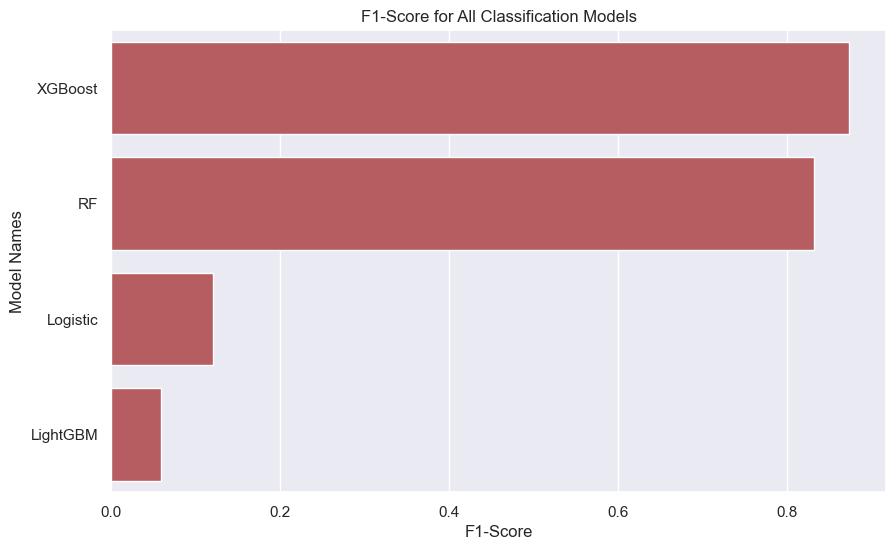

In [24]:
model_results = Create_Train_All_Classification_Models(df, "Class", results=True, save_results=False, plot=True)

# Tuning the Best Model (XGBoost)

In [25]:
def XGBoost_Model_Tuned(dataframe, target, test_size=0.20, cv=5, results=False, conf_matrix=False, c_report=False, roc=False, plot_importance=False, save_model=False):
  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=1)

  xgboost_model = XGBClassifier(eval_metric="logloss", use_label_encoder=False, tree_method="gpu_hist")

  # Hyperparameters
  xgboost_params = {
      "max_depth": [3, 5, 7],  
      "subsample": [0.4, 0.6],
      "n_estimators": [500, 1000],
      "min_child_weight": [1, 3],  
      "learning_rate": [0.1, 0.01]
  }

  # Validation and model tuning
  skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
  xgboost_cv_model = GridSearchCV(xgboost_model, xgboost_params, cv=skf, verbose=True, n_jobs=-1, scoring="f1").fit(X_train, y_train)
  xgboost_model_tuned = XGBClassifier(**xgboost_cv_model.best_params_, eval_metric="logloss", use_label_encoder=False, random_state=42)
  xgboost_model_tuned.fit(X_train, y_train)

  y_pred_train = xgboost_model_tuned.predict(X_train)
  y_pred_test = xgboost_model_tuned.predict(X_test)

  if results:
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    print("="*30, "Model Performance", "="*30)
    print("Best Params: ", xgboost_cv_model.best_params_)
    print("Train Accuracy: ", "%.3f" % acc_train)
    print("Test Accuracy: ", "%.3f" % acc_test)

  if conf_matrix:
    print("="*30, "Confusion Matrix", "="*30)
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

  if c_report:
    print("="*30, "Classification Report", "="*30)
    print(classification_report(y_test, y_pred_test))

  if roc:
    roc_auc_test = roc_auc_score(y_test, y_pred_test)
    fpr, tpr, _ = roc_curve(y_test, xgboost_model_tuned.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, label='AUC = %.3f' % roc_auc_test)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

  if plot_importance:
    feature_imp = pd.DataFrame({'Value': xgboost_model_tuned.feature_importances_, 'Feature': X.columns})
    plt.figure(figsize=(5,5))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title("Feature Importance")
    plt.show()

  if save_model:
    joblib.dump(xgboost_model_tuned, "xgboost_model_tuned.pkl")

  return xgboost_model_tuned

Fitting 5 folds for each of 48 candidates, totalling 240 fits
============================== Model Performance ==============================
Best Params:  {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 0.6}
Train Accuracy:  1.000
Test Accuracy:  1.000
============================== Confusion Matrix ==============================


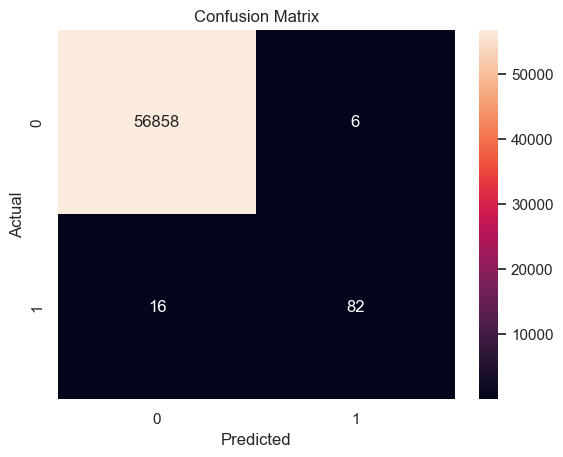

============================== Classification Report ==============================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.84      0.88        98

    accuracy                           1.00     56962
   macro avg       0.97      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962



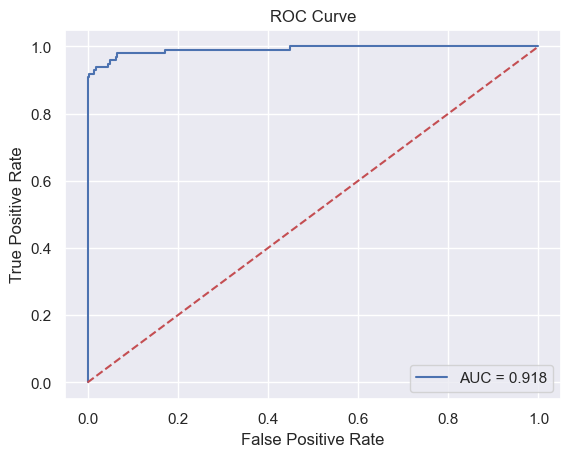

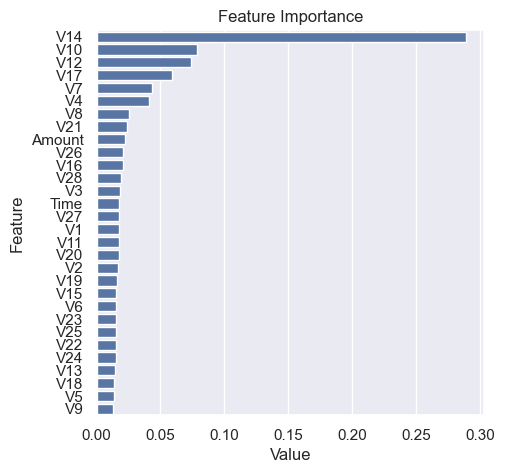

In [26]:
xgboost_model_tuned= XGBoost_Model_Tuned(df, "Class", results=True, conf_matrix=True, c_report=True, roc=True, plot_importance=True, save_model=True)